This notebook looks at regional PV modeling. By regional PV modeling, the modeling of an entire region (such as Germany in this case) is meant.

We illustrate here how tilt and azimuth angles influence the total PV simulation of a country, meaning Germany

# Reading in netcdf

In [1]:
import atlite
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
from atlite.pv.solar_position import SolarPosition
from atlite.pv.irradiation import TiltedIrradiation
from atlite.pv.solar_panel_model import SolarPanelModel
from atlite.pv.orientation import get_orientation, SurfaceOrientation
from atlite.convert import pv, convert_pv, get_orientation,get_solarpanelconfig


In [3]:
ds = xr.open_dataset("assets/data_2017_germany.nc")

In [4]:
ds

<xarray.Dataset>
Dimensions:         (time: 8760, y: 31, x: 37)
Coordinates:
  * time            (time) datetime64[ns] 2017-01-01 ... 2017-12-31T23:00:00
  * x               (x) float32 6.0 6.25 6.5 6.75 7.0 ... 14.25 14.5 14.75 15.0
    lon             (x) float32 ...
  * y               (y) float32 55.0 54.75 54.5 54.25 ... 48.25 48.0 47.75 47.5
    lat             (y) float32 ...
Data variables:
    ssrd            (time, y, x) float32 ...
    albedo          (time, y, x) float32 ...
    influx_diffuse  (time, y, x) float32 ...
    influx_direct   (time, y, x) float32 ...
    influx_toa      (time, y, x) float32 ...
    temperature     (time, y, x) float32 ...
    ssr             (time, y, x) float32 ...

In [5]:
ds["ssrd"].sel({"time":"2017-01-01"})

<xarray.DataArray 'ssrd' (time: 24, y: 31, x: 37)>
array([[[0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.],
        ...,
        [0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.]],

       [[0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.],
        ...,
        [0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.]],

       ...,

       [[0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.],
        ...,
        [0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.]],

       [[0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.],
        ...,
        [0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2017-01-01 ... 2017-01-01T23:00:00
  * x        (x) float32 6.0 6.25 6.5 6.75 7.0 ... 14.0 14.25 14.5 14.75 15.0
    lon      (x) float32 6.0 6.25 6.5 6.75 7.0 ... 14.0 14.25 14.5 14.75 15.0
  * y        (y) float32 55.0 54.75 54.5 54.25 54.0 ... 48.25 48.0 47.75 47.5
    lat      (y) float32 55.0 54.75 54.5 54.25 54.0 ... 48.25 48.0 47.75 47.5
Attributes:
    units:          J m**-2
    long_name:      Surface solar radiation downwards
    standard_name:  surface_downwelling_shortwave_flux_in_air

# PV calculation

In [6]:
layout = xr.open_dataarray("assets/layouts.nc") # [years, y, x]
layout = layout.sel({"time":2017})

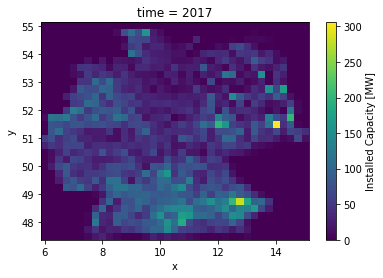

In [7]:
layout.plot()

In [8]:
time_shift = 0 # relevant if sarah-2 data is used
solar_position = SolarPosition(ds, time_shift)
solar_position.load() # this takes some time

<xarray.Dataset>
Dimensions:   (time: 8760, y: 31, x: 37)
Coordinates:
  * time      (time) datetime64[ns] 2017-01-01 ... 2017-12-31T23:00:00
  * y         (y) float32 55.0 54.75 54.5 54.25 54.0 ... 48.25 48.0 47.75 47.5
    lat       (y) float32 55.0 54.75 54.5 54.25 54.0 ... 48.25 48.0 47.75 47.5
  * x         (x) float32 6.0 6.25 6.5 6.75 7.0 ... 14.0 14.25 14.5 14.75 15.0
    lon       (x) float32 6.0 6.25 6.5 6.75 7.0 ... 14.0 14.25 14.5 14.75 15.0
Data variables:
    altitude  (time, y, x) float64 -1.008 -1.008 -1.008 ... -1.143 -1.143 -1.143
    azimuth   (time, y, x) float64 0.1553 0.1628 0.1702 ... 6.232 6.241 6.251

In [9]:
orientation={'slope': 30., 'azimuth': 0.}
panel = "CSi"
panel = get_solarpanelconfig(panel)
orientation_30 = get_orientation(orientation)

surface_orientation = SurfaceOrientation(ds, solar_position, orientation_30)
irradiation = TiltedIrradiation(
    ds,
    solar_position,
    surface_orientation,
    trigon_model="simple",
    clearsky_model="simple",
)
solar_panel = SolarPanelModel(ds, irradiation, panel)
y = (solar_panel * layout)
ysum = y.sum(["x", "y"])


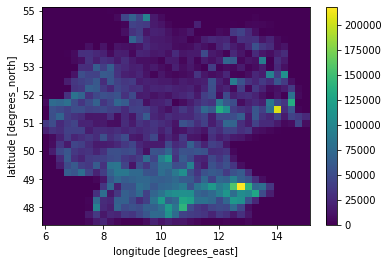

In [10]:
y.sum("time").plot()

Text(0.5, 1.0, 'Exemplary PV generation (2017-06-05 12:00)')

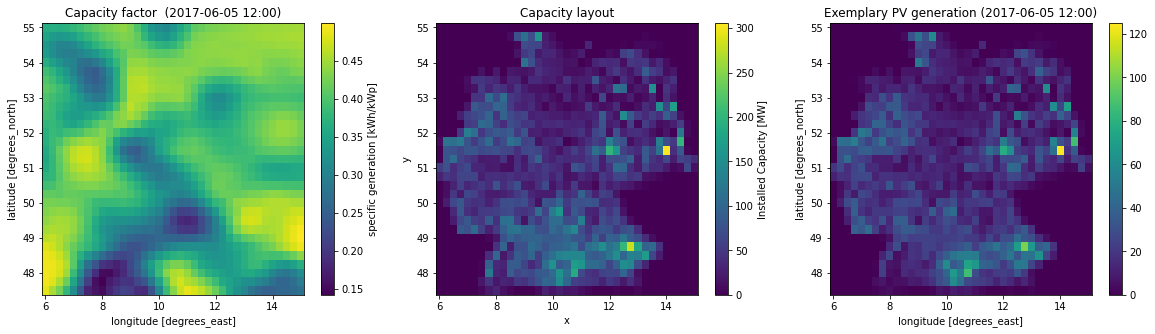

In [11]:
fig,axs=plt.subplots(1,3, figsize=(20,5))
dt = "2017-06-05 12:00"

solar_panel.sel({"time": f"{dt}"}).plot(ax=axs[0])
axs[0].set_title(f"Capacity factor  ({dt})")

layout.plot(ax=axs[1])
axs[1].set_title("Capacity layout")

(solar_panel*layout).sel({"time":f"{dt}"}).plot(ax=axs[2])
axs[2].set_title(f"Exemplary PV generation ({dt})")


# Analysis

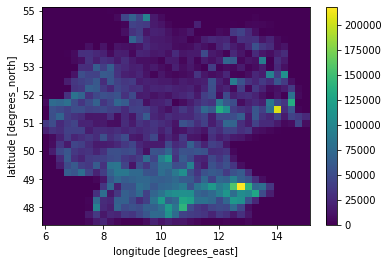

In [12]:
y.sum("time").plot()

In [13]:
ysum.sel({"time":"2017-06-01"})

<xarray.DataArray (time: 24)>
array([    0.        ,     0.        ,     0.        ,     0.        ,
         564.60049386,  3967.54118637,  7926.59982166, 10917.20652966,
       13968.5236547 , 16045.41627178, 17707.51356819, 18712.2421113 ,
       19304.11645839, 18998.25193876, 17871.83771328, 15892.02371466,
       13807.54253709, 11260.14251025,  8067.06503788,  5680.03004871,
           0.        ,     0.        ,     0.        ,     0.        ])
Coordinates:
  * time     (time) datetime64[ns] 2017-06-01 ... 2017-06-01T23:00:00

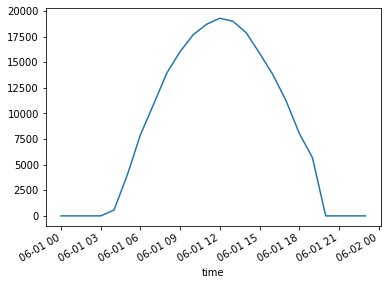

In [14]:
ysum.sel({"time":"2017-06-01"}).plot()

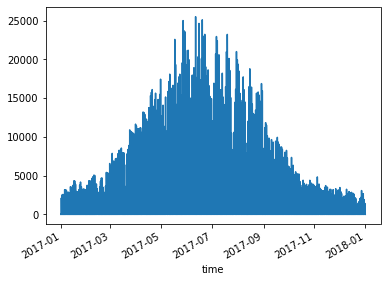

In [15]:
ysum.plot()

# How do the tilt angles and azimuth orientations affect the output? 

## Azimuth angles 

In [16]:
def make_azimuth(tilt, azimuth):
    orientation={'slope': tilt, 'azimuth': azimuth}
    panel = "CSi"
    panel = get_solarpanelconfig(panel)
    orientation_30 = get_orientation(orientation)

    surface_orientation = SurfaceOrientation(ds, solar_position, orientation_30)
    irradiation = TiltedIrradiation(
        ds,
        solar_position,
        surface_orientation,
        trigon_model="simple",
        clearsky_model="simple",
    )
    solar_panel = SolarPanelModel(ds, irradiation, panel)
    y = (solar_panel * layout)
    ysum = y.sum(["x", "y"])
    return ysum




In [17]:
azimuths = [90,180,270]
#tilts = [0, 30, 90]
ysums=[]
for azimuth in azimuths:
    print(azimuth)
    ysums.append(make_azimuth(30, azimuth))

90
180
270


Text(0.5, 1.0, 'diurnal cycle azimuth angle \n (winter)')

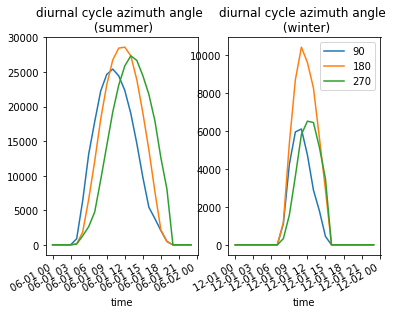

In [18]:
fig, axs = plt.subplots(1,2)

ysums[0].sel({"time":"2017-06-01"}).plot(ax=axs[0])
ysums[1].sel({"time":"2017-06-01"}).plot(ax=axs[0])
ysums[2].sel({"time":"2017-06-01"}).plot(ax=axs[0])

ysums[0].sel({"time":"2017-12-01"}).plot(ax=axs[1])
ysums[1].sel({"time":"2017-12-01"}).plot(ax=axs[1])
ysums[2].sel({"time":"2017-12-01"}).plot(ax=axs[1])

plt.legend(azimuths)
axs[0].set_title("diurnal cycle azimuth angle \n (summer)")
axs[1].set_title("diurnal cycle azimuth angle \n (winter)")

Text(0.5, 1.0, 'diurnal cycle azimuth angle \n (winter)')

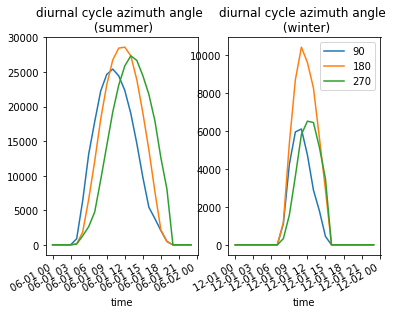

In [19]:
fig, axs = plt.subplots(1,2)

ysums[0].sel({"time":"2017-06-01"}).plot(ax=axs[0])
ysums[1].sel({"time":"2017-06-01"}).plot(ax=axs[0])
ysums[2].sel({"time":"2017-06-01"}).plot(ax=axs[0])

ysums[0].sel({"time":"2017-12-01"}).plot(ax=axs[1])
ysums[1].sel({"time":"2017-12-01"}).plot(ax=axs[1])
ysums[2].sel({"time":"2017-12-01"}).plot(ax=axs[1])

plt.legend(azimuths)
axs[0].set_title("diurnal cycle azimuth angle \n (summer)")
axs[1].set_title("diurnal cycle azimuth angle \n (winter)")

## Tilt angle

In [20]:
tilts = [0, 30, 60]
ysums2=[]
for tilt in tilts:
    print(tilt)
    ysums2.append(make_azimuth(tilt, 180))

0
30
60


Text(0.5, 1.0, 'diurnal cycle tilts angle \n (winter)')

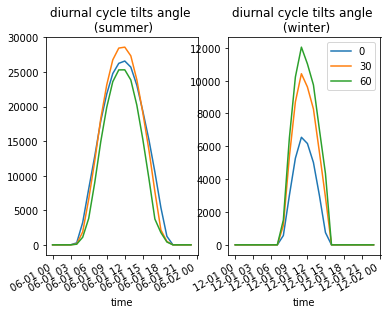

In [21]:
fig, axs = plt.subplots(1,2)

ysums2[0].sel({"time":"2017-06-01"}).plot(ax=axs[0])
ysums2[1].sel({"time":"2017-06-01"}).plot(ax=axs[0])
ysums2[2].sel({"time":"2017-06-01"}).plot(ax=axs[0])

ysums2[0].sel({"time":"2017-12-01"}).plot(ax=axs[1])
ysums2[1].sel({"time":"2017-12-01"}).plot(ax=axs[1])
ysums2[2].sel({"time":"2017-12-01"}).plot(ax=axs[1])

plt.legend(tilts)
axs[0].set_title("diurnal cycle tilts angle \n (summer)")
axs[1].set_title("diurnal cycle tilts angle \n (winter)")

Text(0.5, 1.0, 'diurnal cycle tilts angle \n (winter)')

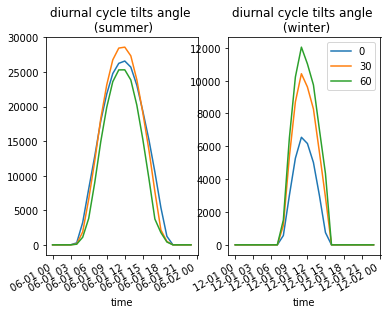

In [22]:
fig, axs = plt.subplots(1,2)

ysums2[0].sel({"time":"2017-06-01"}).plot(ax=axs[0])
ysums2[1].sel({"time":"2017-06-01"}).plot(ax=axs[0])
ysums2[2].sel({"time":"2017-06-01"}).plot(ax=axs[0])

ysums2[0].sel({"time":"2017-12-01"}).plot(ax=axs[1])
ysums2[1].sel({"time":"2017-12-01"}).plot(ax=axs[1])
ysums2[2].sel({"time":"2017-12-01"}).plot(ax=axs[1])

plt.legend(tilts)
axs[0].set_title("diurnal cycle tilts angle \n (summer)")
axs[1].set_title("diurnal cycle tilts angle \n (winter)")